# PSI3532 - Filtragem Adaptativa e Aplicações - P1
Henrique Souza de Melo - 9347031

In [1]:
import numpy as np
from numpy import pi, cos
from scipy import signal
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

## Definindo o filtro

In [2]:
class LMS:
    """
    Implementation of LMS adaptive filter.
    """
    def __init__(self, M=5, mu=.03):
        """
        Create an LMS adaptive filter.

        Parameters
        ----------
        M : int, optional
            Filter dimension. If not given, will be set to standard size of 5
            coefficients.
        mu : float, optional
            Adaptive filter step. If not given, will be set to standard of .03.
            Larger step size will possibly result in fastest convergence but less
            precision. If too large will lead to divergence.
        
        Returns
        -------
        out : LMS object
            Implementation of LMS adaptive filter.
        """
        self.M = M
        self.mu = mu
        
        self.x = np.array([]) #buffer x
        self.phi = np.array([np.zeros(self.M)] * (self.M - 1))
        
        self.W = np.array([np.zeros(self.M)] * (self.M - 1)) #filter coefficients - array of arrays of M coefficients
        self.y_ = np.zeros(self.M - 1) #filter output
        self.e = np.array([]) #filter error
        
    def buffer(self, x, d):
        """
        Filter input. x[n] and d[n] values are passed to the filter through this 
        method.
        The filter will automatically compute its output and update w values 
        after the first M samples of x and d are received. After that, the filter
        will be updated after each new input.

        Parameters
        ----------
        x : float
            One sample of x[n] signal.
        d : float
            One sample of d[n] signal.
        
        Returns
        -------
        None
        """
        self.x = np.append(self.x, x)
        if(len(self.x) == self.M):
            self.update(d)
        else:
            self.e = np.append(self.e, d - self.y_[-1])
            
    def update(self, d):
        """
        Update the filter coefficients and calculate its output. This method is
        automatically called on the correct moments by the 'buffer' routine.
        
        Parameters
        ----------
        d : float
            Current sample of d[n] signal.
        
        Returns
        -------
        None
        """
        X = np.flip(self.x, axis=0) #X[n]
        phi_new = [[x ** 3 / (1 + x ** 2) for x in X]]
        self.phi = np.concatenate((self.phi, phi_new))
        
        self.y_ = np.append(self.y_, np.dot(self.phi[-1], self.W[-1])) #y_[n]
        self.e = np.append(self.e, d - self.y_[-1]) #e[n]
        
        W_new = [self.W[-1] + self.mu * self.e[-1] * self.phi[-1]] #W[n+1]
        self.W = np.concatenate((self.W, W_new)) 
        
        self.x = np.delete(self.x, 0) #delete oldest buffer element



## Executando o filtro nas condições solicitadas

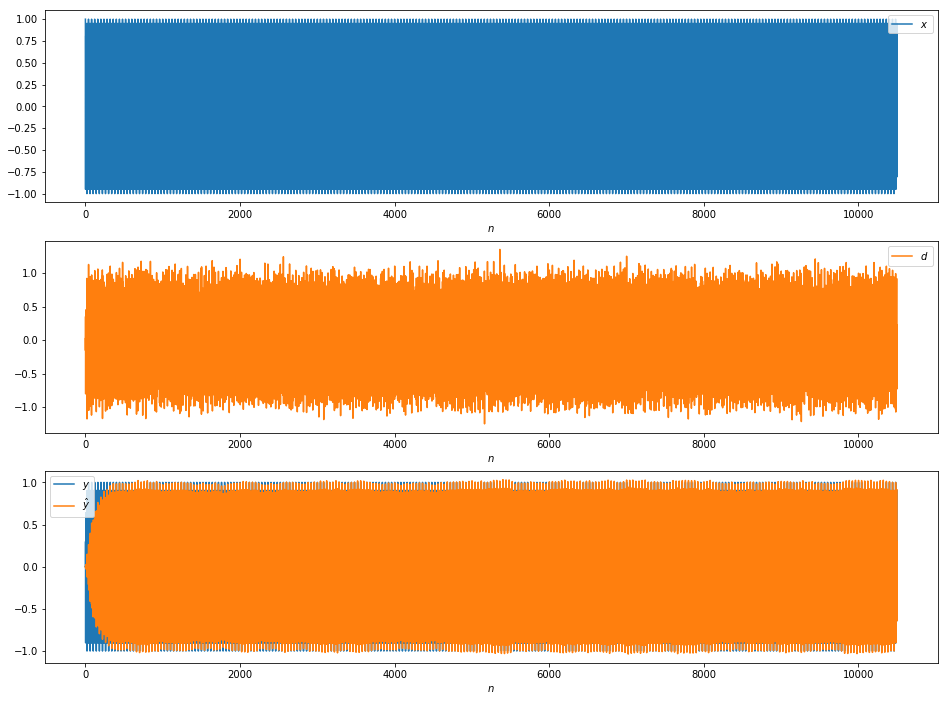

In [3]:
mu = .2
lms_filter = LMS(M=3, mu=mu)

n = np.arange(start=0, stop=10500)
v = np.random.randn(len(n)) * np.sqrt(.01)
omega_0 = pi / 2
omega_s = pi / 20
x = cos(omega_0 * n) * cos(omega_s * n)

a = 1
b = 2
c = 1.5
y = np.zeros(len(x))
f = lambda x, n : x[n] ** 3 / (1 + x[n] ** 2)
for i in range(2, len(x)):
    y[i] = a * f(x, i) + b * f(x, i-1) + c * f(x, i-2)
d = y + v

for i in range(len(d)):
    lms_filter.buffer(x[i], d[i])

phi_product = np.zeros((len(lms_filter.phi),3,3))
for i in range(len(phi_product)):
    phi_product[i] += np.matmul(np.reshape(lms_filter.phi[i], (3,1)), np.matrix(lms_filter.phi[i]))
R_phi = np.mean(phi_product, axis=0)

dphi = np.zeros((len(lms_filter.phi),3,1))
for i in range(len(dphi)):
    dphi[i] += d[i] * np.reshape(lms_filter.phi[i], newshape=(3,1))
r_dphi = np.mean(dphi, axis=0)

W_o = np.linalg.solve(a=R_phi, b=r_dphi)

#plotando resultado
plt.figure(figsize=(16,12))

ax0 = plt.subplot(311)
plt.plot(n , x)
plt.xlabel('$n$')
plt.legend(['$x$'])

plt.subplot(312, sharex=ax0)
plt.plot(n, d, color='C1')
plt.legend(['$d$'])
plt.xlabel('$n$')

plt.subplot(313, sharex=ax0)
plt.plot(n, y, n, lms_filter.y_)
plt.xlabel('$n$')
plt.legend(['$y$', '$\hat{y}$'])

## Coeficientes ótimos aproximados

In [4]:
W_o

array([[0.99112273],
       [1.9986066 ],
       [1.48785343]])

## Taxa de convergência

In [5]:
(1 - mu) * np.linalg.eigvals(R_phi)

array([0.00257443, 0.07018306, 0.036377  ])

## Coeficientes calculados

Text(0.5, 1.0, 'Convergência dos coeficientes para $a=1$, $b=2$ e $c=1.5$')

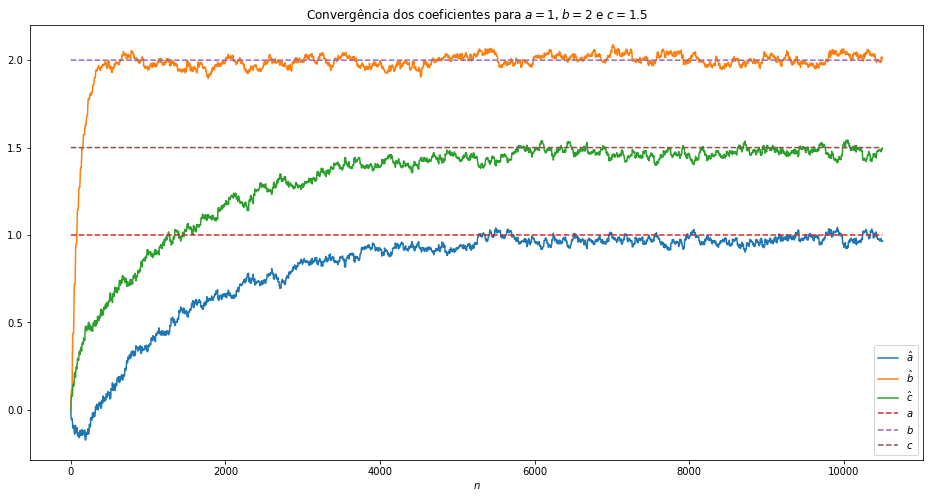

In [6]:
plt.figure(figsize=(16,8))
plt.plot(n, lms_filter.W[:,0], n, lms_filter.W[:,1], n, lms_filter.W[:,2])
plt.plot(n, np.ones(len(n)) * a, '--', n, np.ones(len(n)) * b, '--', n, np.ones(len(n)) * c, '--')
plt.legend([r'$\hat{a}$', r'$\hat{b}$', r'$\hat{c}$',
            r'$a$', r'$b$', r'$c$'])
plt.xlabel(r'$n$')
plt.title('Convergência dos coeficientes para $a={a}$, $b={b}$ e $c={c}$'.format(a=a,b=b,c=c))